# AI for Medical

## Multiclass Image Classification
## Using Chest X-Ray Images [Covid-19, Pneumonia, Normal Chest]

#### Importing Libraries

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils


## Configuring GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
print(f"List of GPU's on this machine : {len(gpus)}")

List of GPU's on this machine : 1


In [4]:
for gpu in gpus :
   tf.config.experimental.set_memory_growth(gpu,True) #This code optimizes the GPU Use 

In [5]:
train_dir = './Data/train'
test_dir = './Data/test/'
val_dir = './Data/val/'

## Visualizing The Images according to their Classes

In [6]:
classes = os.listdir('./Data/train')

In [7]:
classes

['COVID19', 'NORMAL', 'PNEUMONIA']

In [8]:
#Maping the sub folders  

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + '/' + c + '/' + x, os.listdir(train_dir + '/' + c)))

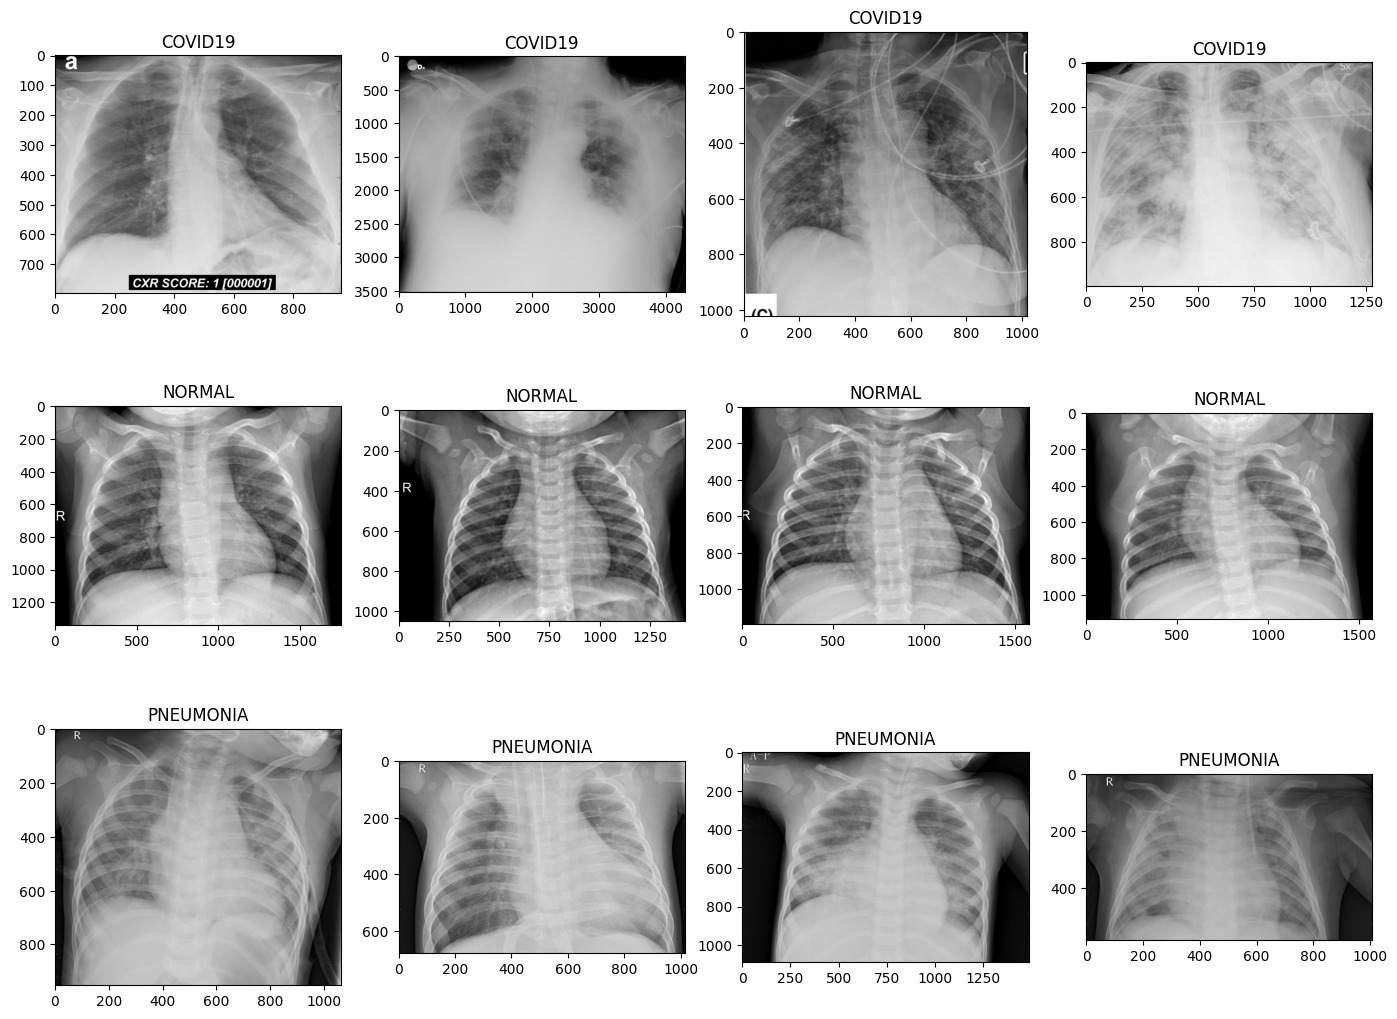

In [9]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [10]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []
print('Training Set Image Count : ')
for i in os.listdir('./Data/train'):
  train_class = os.listdir(os.path.join('./Data/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} '.format(i, len(train_class)))

print("\nTrain Set Total Images : ",len(os.listdir("./Data/train/PNEUMONIA")) +
      len(os.listdir("./Data/train/NORMAL")) +
      len(os.listdir("./Data/train/COVID19")))
print("=======================================")
print('Validation Set Image Count : ')
for i in os.listdir('./Data/val'):
  train_class = os.listdir(os.path.join('./Data/val', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} '.format(i, len(train_class)))
print("\nTrain Set Total Images : ",len(os.listdir("./Data/val/PNEUMONIA")) +
      len(os.listdir("./Data/val/NORMAL")) +
      len(os.listdir("./Data/val/COVID19")))
print("=======================================")
print('Test Set Image Count : ')
for i in os.listdir('./Data/test'):
  train_class = os.listdir(os.path.join('./Data/test', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} '.format(i, len(train_class)))
print("\nTrain Set Total Images : ",len(os.listdir("./Data/test/PNEUMONIA")) +
      len(os.listdir("./Data/test/NORMAL")) +
      len(os.listdir("./Data/test/COVID19")))


Training Set Image Count : 
Number of images in COVID19 = 416 
Number of images in NORMAL = 1144 
Number of images in PNEUMONIA = 3064 

Train Set Total Images :  4624
Validation Set Image Count : 
Number of images in COVID19 = 102 
Number of images in NORMAL = 282 
Number of images in PNEUMONIA = 768 

Train Set Total Images :  1152
Test Set Image Count : 
Number of images in COVID19 = 58 
Number of images in NORMAL = 157 
Number of images in PNEUMONIA = 441 

Train Set Total Images :  656


# Creating Image Dataset

In [11]:
#Creating Image Data generating Function by calling ImageDataGenerator from tensorflow.keras.preprocessing.image
datagen = ImageDataGenerator(rotation_range=20,
                             height_shift_range=0.1,
                             shear_range=0.1,
                            zoom_range=0.1,
                            samplewise_center=True,
                            samplewise_std_normalization=True)

In [12]:
#Passing the train test and val data to the function
train_data = datagen.flow_from_directory(train_dir,
                                         target_size=(320, 320),
                                         batch_size=8,
                                         shuffle=True,
                                         class_mode='categorical'
                                         )

valid_data = datagen.flow_from_directory(val_dir,
                                         target_size=(320, 320),
                                         batch_size=1,                   #Needed to change
                                         shuffle=True,
                                         class_mode='categorical'
                                         )

test_data = datagen.flow_from_directory(test_dir,
                                        batch_size=1, 
                                         target_size=(320, 320),
                                         class_mode='categorical',
                                         shuffle=False)
                                        

Found 4624 images belonging to 3 classes.
Found 1152 images belonging to 3 classes.
Found 656 images belonging to 3 classes.


In [13]:
#view the class dictionary
print(train_data.class_indices)
print(valid_data.class_indices)
print(test_data.class_indices)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 2.7848 and the minimum is -2.7879
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


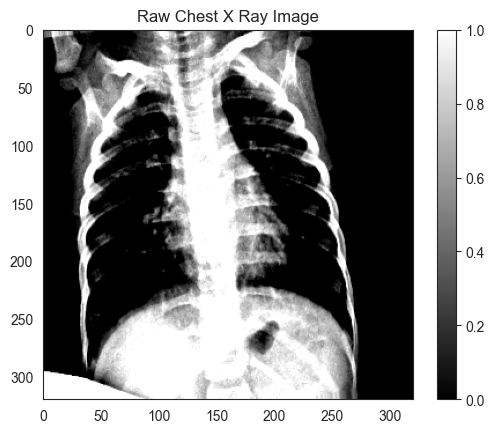

In [14]:
sns.set_style('white')
generated_image, label = train_data.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

C:\Users\nahia\AppData\Local\Temp\ipykernel_8476\4033312467.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

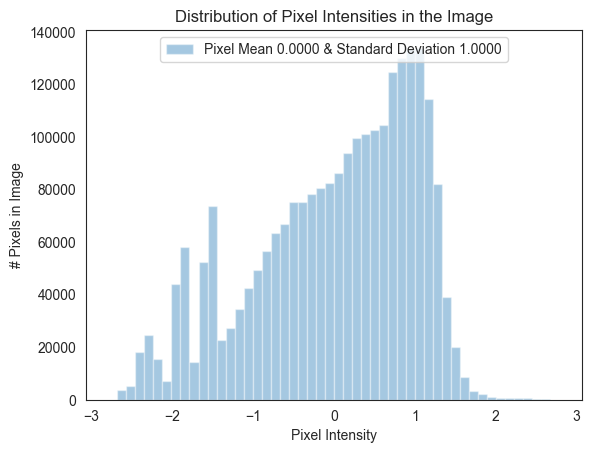

In [15]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 🤖 Model Building Architecture

### We are going to try 2 pre trained Model : ResNet50 and Effnet
#### 1. ResNet50


In [16]:
#ResNet50

from keras.applications.resnet import ResNet50
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(320, 320, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation='softmax')(model)
model= Model(inputs=net.input,
              outputs=model)

#get summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 🤖 Compiling ResNet50

In [17]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
# checkpoint = ModelCheckpoint('model.h5', 
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              mode='auto',
#                              verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

# 🤖 Training ResNet50

In [18]:
%%time

#train the model
history = model.fit(train_data,
                    epochs = 15,
                    # batch_size=16,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/15
578/578 [==============================] - 283s 462ms/step - loss: 0.2266 - accuracy: 0.9200 - val_loss: 1.6692 - val_accuracy: 0.3872 - lr: 1.0000e-04
Epoch 2/15
578/578 [==============================] - 258s 447ms/step - loss: 0.1425 - accuracy: 0.9570 - val_loss: 0.1423 - val_accuracy: 0.9427 - lr: 1.0000e-04
Epoch 3/15
578/578 [==============================] - 248s 428ms/step - loss: 0.1007 - accuracy: 0.9619 - val_loss: 0.0708 - val_accuracy: 0.9783 - lr: 1.0000e-04
Epoch 4/15
578/578 [==============================] - 249s 431ms/step - loss: 0.0902 - accuracy: 0.9706 - val_loss: 0.0762 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 5/15
578/578 [==============================] - 254s 439ms/step - loss: 0.0898 - accuracy: 0.9680 - val_loss: 0.0654 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 6/15
578/578 [==============================] - 251s 433ms/step - loss: 0.0822 - accuracy: 0.9710 - val_loss: 0.0688 - val_accuracy: 0.9731 - lr: 1.0000e-04
Epoch 7/15
578/578 [==

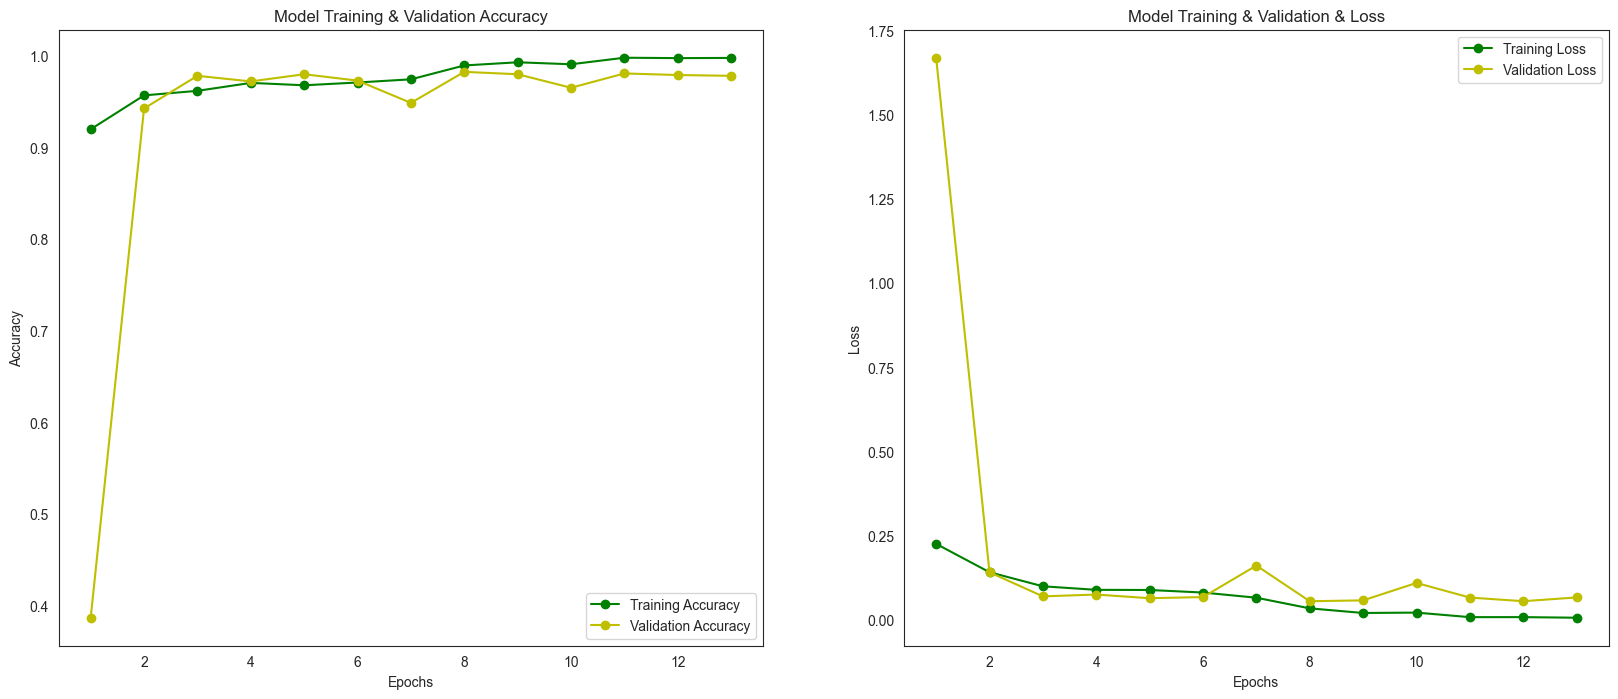

In [19]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [20]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

578/578 [==============================] - 153s 265ms/step - loss: 0.0046 - accuracy: 0.9985
Train accuracy & loss: [0.004584851209074259, 0.9984861612319946]


656/656 [==============================] - 33s 50ms/step - loss: 0.0307 - accuracy: 0.9878
Test accuracy & loss: [0.030735498294234276, 0.9878048896789551]


In [21]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

656/656 [==============================] - 26s 39ms/step


In [22]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [23]:
yhat_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[ 58   0   0]
 [  0 153   4]
 [  0   3 438]]


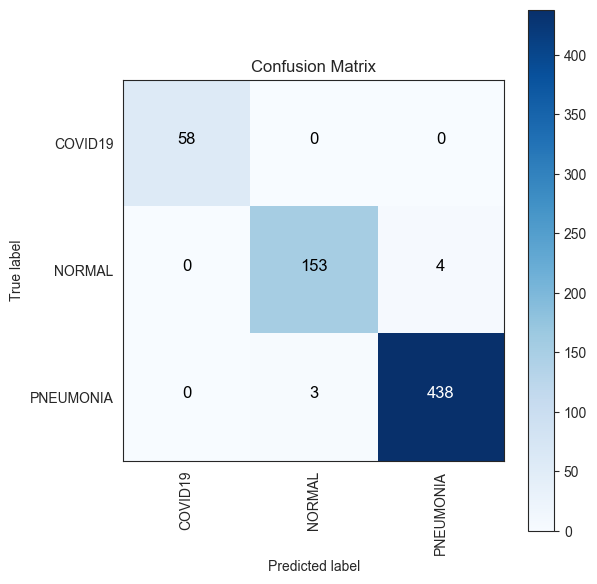

In [25]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [26]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.98      0.97      0.98       157
           2       0.99      0.99      0.99       441

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [28]:
#Accurate Formato to Save and Load outside this notebook

model.save("trained_model_ResNet50.h5")

In [27]:
# import pickle
# from tensorflow.keras.models import load_model
# from tensorflow.keras.applications import ResNet50



# # Save the model using pickle
# model_filename = 'trained_model_ResNet50.pkl'

# # Save the model
# with open(model_filename, 'wb') as model_file:
#     pickle.dump(model, model_file)

# print(f"Trained model saved as '{model_filename}'")

In [ ]:
# model.save("normal_trained_model_ResNet50")